# **EXPERIMENT B**

## *1. Installs:*

In [ ]:
# Pip installs:
!pip install kaggle
!pip install focal-loss
!pip install vit-keras
!pip install tensorflow_addons
!pip install tfswin
!pip install keras-tuner --upgrade

In [ ]:
# Library installs:
import os
import gc
import cv2
import sys
import math
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import zipfile
import PIL
from PIL import Image
import skimage.io
from skimage.transform import resize
from imgaug import augmenters as iaa
from tqdm import tqdm
from sklearn.utils import class_weight, shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import keras_tuner
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, Input, BatchNormalization, Conv2D, Reshape, Lambda, Concatenate, Average
from keras.models import Model
from keras.applications import EfficientNetV2M, ConvNeXtBase
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, BackupAndRestore, LearningRateScheduler
from keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from keras import metrics
from tensorflow.keras import regularizers
from keras.optimizers import Adam
from focal_loss import BinaryFocalLoss
from keras import backend as K
from vit_keras import vit
from tfswin import SwinTransformerBase224

import warnings
warnings.filterwarnings('ignore')

## *2. Importing Dataset:*

### 2.1 Global GPU policy:

In [3]:
# Defining global policy to speed up computations:
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
except ValueError:
  tpu = None

if tpu:
  policyConfig = 'mixed_bfloat16'
else: 
  policyConfig = 'mixed_float16'
policy = tf.keras.mixed_precision.Policy(policyConfig)
tf.keras.mixed_precision.set_global_policy(policy)

### 2.2 Downloading HPA dataset:

In [ ]:
# Connecting to Google Drive:
# drive.mount('/content/drive')

In [4]:
# Creating Kaggle directory:
!mkdir -p ~/.kaggle

In [5]:
# Moving Kaggle API credentials to Kaggle directory:
!cp /content/drive/MyDrive/Colab\ Notebooks/kaggle.json ~/.kaggle/kaggle.json

In [6]:
# Retrieving permission:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading the dataset:
!kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
# Unzipping dataset:
!unzip human-protein-atlas-image-classification.zip

### 2.3 Loading dataset information:

In [9]:
# Defining constants, seed & paths:
epochs = 30
batch_size = 32
SIZE = (224, 224, 3)

seed = 123

path_to_images = '/content/train' # contains 31.072 images, distributed over 4 filter channels.
data = pd.read_csv('/content/train.csv') # contains 31.072 image IDs and labels.

In [10]:
# Checking the labels:
print(data.head())
print(len(data))

                                     Id   Target
0  00070df0-bbc3-11e8-b2bc-ac1f6b6435d0     16 0
1  000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0  7 1 2 0
2  000a9596-bbc4-11e8-b2bc-ac1f6b6435d0        5
3  000c99ba-bba4-11e8-b2b9-ac1f6b6435d0        1
4  001838f8-bbca-11e8-b2bc-ac1f6b6435d0       18
31072


In [11]:
# Count number of images & check:
lst = os.listdir(path_to_images)
number_images = len(lst)
print(number_images)
print((number_images / 4) == len(data))

124288
True


In [12]:
# Acquiring dataset information:
dataset_info = []
for name, labels in zip(data['Id'], data['Target'].str.split(' ')):
    dataset_info.append({
        'path':os.path.join(path_to_images, name),
        'labels':np.array([int(label) for label in labels])})
dataset_info = np.array(dataset_info)

In [13]:
# Getting image sample:
print(dataset_info[0])

{'path': '/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0', 'labels': array([16,  0])}


In [14]:
# Extracting individual directories from sample:
print(dataset_info[0]['path'])
print(dataset_info[0]['labels'])

/content/train/00070df0-bbc3-11e8-b2bc-ac1f6b6435d0
[16  0]


## *3. Pre-processing:*

### 3.1 Train, validation & test set split:

In [15]:
random.seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

indexes = np.arange(dataset_info.shape[0])
np.random.shuffle(indexes)

# Splitting the data into a train set and temporary set:
train_indexes, temp_indexes = train_test_split(indexes,
                                               test_size = 0.2,
                                               random_state = seed)

# Splitting the temporary set further into a validation & test set:
val_indexes, test_indexes = train_test_split(temp_indexes,
                                             test_size = 0.5,
                                             random_state = seed)

# Concatenating the training and validation set for training the final models:
final_train_indexes = np.concatenate((train_indexes, val_indexes))

In [16]:
# Checking the proportions:
print(train_indexes.shape,
      val_indexes.shape,
      test_indexes.shape,
      final_train_indexes.shape)

(24857,) (3107,) (3108,) (27964,)


### 3.2 Creating data generator:

In [17]:
# Custom data generator function, including reshaping, normalization & augmentation:
class data_generator:
    
    def create_train(dataset_info, batch_size, shape, aug = True):
        assert shape[2] == 3
        while True:
            dataset_info = shuffle(dataset_info)
            for start in range(0, len(dataset_info), batch_size):
                end = min(start + batch_size, len(dataset_info))
                batch_images = []
                X_train_batch = dataset_info[start:end]
                batch_labels = np.zeros((len(X_train_batch), 28))
                for i in range(len(X_train_batch)):
                    image = data_generator.load_image(
                        X_train_batch[i]['path'], shape)   
                    if aug:
                        image = data_generator.augment(image)
                    batch_images.append(image/255.)
                    batch_labels[i][X_train_batch[i]['labels']] = 1
                yield np.array(batch_images, np.float32), batch_labels

    def load_image(path, shape):
        image_red_ch = Image.open(path + '_red.png')
        image_yellow_ch = Image.open(path + '_yellow.png')
        image_green_ch = Image.open(path + '_green.png')
        image_blue_ch = Image.open(path + '_blue.png')
        image = np.stack((
        np.array(image_red_ch), 
        np.array(image_green_ch), 
        np.array(image_blue_ch)), -1)
        image = cv2.resize(image, (shape[0], shape[1]))
        return image

    def augment(image):
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(shear = (-10, 10)),
                iaa.Affine(rotate = 0),
                iaa.Affine(rotate = 90),
                iaa.Affine(rotate = 180),
                iaa.Affine(rotate = 270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order = True)

        image_aug = augment_img.augment_image(image)
        return image_aug

In [18]:
# Creating train, validation and test data generator:
train_generator = data_generator.create_train(
    dataset_info[train_indexes],
    batch_size,
    SIZE,
    aug = True) # Set to true in this experiment!

validation_generator = data_generator.create_train(
    dataset_info[val_indexes],
    batch_size,
    SIZE,
    aug = False)

test_generator = data_generator.create_train(
    dataset_info[test_indexes],
    batch_size,
    SIZE,
    aug = False)

In [19]:
# Creating final train generator to train final models after hyperparameter tuning:
final_train_generator = data_generator.create_train(
    dataset_info[final_train_indexes],
    batch_size,
    SIZE,
    aug = True) # Set to true in this experiment!

## *4. Hyperparameter Tuning:*

In [ ]:
# Defining EarlyStopping, ReduceLROnPlateau & BackupAndRestore for tuning:
hp_early_stopping = EarlyStopping(monitor = 'val_loss',
                                  mode = 'min',
                                  patience = 4)

hp_reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                                factor = 0.1,
                                patience = 2,
                                verbose = 0,
                                mode = 'auto',
                                min_lr = 1e-4)

hp_restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/AUG/backup',
                              save_freq = 'epoch',
                              delete_checkpoint = True)

In [ ]:
# Custom callback against memory leakage:
class ClearMemory(Callback):
  def on_epoch_end(self, epoch, logs = None):
    gc.collect()
    K.clear_session()

In [ ]:
# Creating callback list:
hp_callbacks_list = [hp_early_stopping,
                     hp_reduceLR,
                     hp_restore,
                     ClearMemory()]

### 4.1 EfficientNet-V2M:

In [ ]:
# Defining the EfficientNet-V2M hyperparameter tuning model function:
def create_efficientnet_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = EfficientNetV2M(include_top = False,
                               weights = 'imagenet',
                               input_shape = SIZE)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc')])
  return model

In [ ]:
# Creating the EfficientNet-V2M tuner:
efficientnet_tuner = keras_tuner.BayesianOptimization(create_efficientnet_hp,
                                                      objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                                      max_trials = 7,
                                                      seed = seed)

In [ ]:
# Summarizing the EfficientNet-V2M tuner:
efficientnet_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the EfficientNet-V2M model:
efficientnet_hp_start_time = time.time()

efficientnet_tuner.search(train_generator,
                          steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                          epochs = 20,
                          validation_data = validation_generator,
                          validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                          verbose = 1,
                          callbacks = hp_callbacks_list)

efficientnet_hp_end_time = time.time()

Trial 7 Complete [01h 33m 39s]
val_recall: 0.26839911937713623

Best val_recall So Far: 0.31948819756507874
Total elapsed time: 10h 46m 40s


In [ ]:
# Total time taken to tune EfficientNet-V2M model:
print("Time taken:", efficientnet_hp_end_time - efficientnet_hp_start_time, "seconds.")

Time taken: 38799.71188902855 seconds.


In [ ]:
# Extracting best hyperparameters EfficientNet-V2M model:
efficientnet_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.31948819756507874

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.30907636880874634

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.307935893535614

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.2935943007469177

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.26839911937713623

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.253814160823822

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.24094708263874054


### 4.2 ConvNeXt-B:

In [ ]:
# Defining the ConvNeXt-B hyperparameter tuning model function:
def create_convnext_hp(hp):
  inputs = Input(shape = SIZE)
  policyConfig = 'float32'
  prev_policy = tf.keras.mixed_precision.global_policy()
  tf.keras.mixed_precision.set_global_policy(policyConfig) # Add this, to make it compatible with global policy!
  pretrained = ConvNeXtBase(include_top = False,
                               weights = 'imagenet',
                               input_shape = SIZE)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the ConvNeXt-B tuner:
convnext_tuner = keras_tuner.BayesianOptimization(create_convnext_hp,
                                                  objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                                  max_trials = 7,
                                                  seed = seed)

In [ ]:
# Summarizing the ConvNeXt-B tuner:
convnext_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the ConvNeXt-B model:
convnext_hp_start_time = time.time()

convnext_tuner.search(train_generator,
                      steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                      epochs = 20,
                      validation_data = validation_generator,
                      validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                      verbose = 1,
                      callbacks = hp_callbacks_list)

convnext_hp_end_time = time.time()

Trial 7 Complete [01h 34m 42s]
val_recall: 0.3081798255443573

Best val_recall So Far: 0.38274291157722473
Total elapsed time: 10h 35m 43s


In [ ]:
# Total time taken to tune ConvNext-B model:
print("Time taken:", convnext_hp_end_time - convnext_hp_start_time, "seconds.")

Time taken: 38143.18396234512 seconds.


In [ ]:
# Extracting best hyperparameters ConvNeXt-B model:
convnext_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.38274291157722473

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.3661331832408905

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.34962552785873413

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.34954527020454407

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.3140396475791931

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.3081798255443573

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.28628548979759216


### 4.3 ViT-B16:

In [ ]:
# Defining the ViT-B16 hyperparameter tuning model function:
def create_vit_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = vit.vit_b16(include_top = False,
                           pretrained = True,
                           pretrained_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the ViT-B16 tuner:
vit_tuner = keras_tuner.BayesianOptimization(create_vit_hp,
                                             objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                             max_trials = 7,
                                             seed = seed)

In [ ]:
# Summarizing the ViT-B16 tuner:
vit_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the ViT-B16 model:
vit_hp_start_time = time.time()

vit_tuner.search(train_generator,
                 steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                 epochs = 20,
                 validation_data = validation_generator,
                 validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                 verbose = 1,
                 callbacks = hp_callbacks_list)

vit_hp_end_time = time.time()

Trial 7 Complete [01h 31m 44s]
val_recall: 0.3033091723918915

Best val_recall So Far: 0.3448959290981293
Total elapsed time: 10h 15m 41s


In [ ]:
# Total time taken to tune ViT-B16 model:
print("Time taken:", vit_hp_end_time - vit_hp_start_time, "seconds.")

Time taken: 36940.643446445465 seconds.


In [ ]:
# Extracting best hyperparameters ViT-B16 model:
vit_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.3448959290981293

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.3033091723918915

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.28866589069366455

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.28341609239578247

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.2678571343421936

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.25306203961372375

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.24198593199253082


### 4.4 Swin-B Transformer:

In [ ]:
# Defining the Swin-B Transformer hyperparameter tuning model function:
def create_swin_hp(hp):
  inputs = Input(shape = SIZE)
  pretrained = SwinTransformerBase224(include_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  x = Dense(units = hp.Choice('units', [128, 256, 512]),
            activation = hp.Choice('activation', ['relu', 'gelu']))(x)
  x = Dropout(rate = hp.Choice('rate', [0.3, 0.4, 0.5]))(x)
  output = Dense(28,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  model.compile(
      loss = BinaryFocalLoss(gamma = 2),
      optimizer = Adam(1e-3),
      metrics = ['binary_accuracy',
                 tf.keras.metrics.Precision(name = 'precision'),
                 tf.keras.metrics.Recall(name = 'recall'),
                 tf.keras.metrics.AUC(name = 'auc',
                                      multi_label = True)])
  return model

In [ ]:
# Creating the Swin-B Transformer tuner:
swin_tuner = keras_tuner.BayesianOptimization(create_swin_hp,
                                              objective = keras_tuner.Objective('val_recall', direction = 'max'),
                                              max_trials = 7,
                                              seed = seed)

In [ ]:
# Summarizing the Swin-B Transformer tuner:
swin_tuner.search_space_summary()

Search space summary
Default search space size: 3
rate (Choice)
{'default': 0.3, 'conditions': [], 'values': [0.3, 0.4, 0.5], 'ordered': True}
units (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512], 'ordered': True}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'gelu'], 'ordered': False}


In [ ]:
# Searching for the best hyperparameters for the Swin-B Transformer model:
swin_hp_start_time = time.time()

swin_tuner.search(train_generator,
                  steps_per_epoch = np.ceil(float(len(train_indexes)) / float(batch_size)),
                  epochs = 20,
                  validation_data = validation_generator,
                  validation_steps = np.ceil(float(len(val_indexes)) / float(batch_size)),
                  verbose = 1,
                  callbacks = hp_callbacks_list)

swin_hp_end_time = time.time()

Trial 7 Complete [01h 36m 27s]
val_recall: 0.2399362325668335

Best val_recall So Far: 0.2937104403972626
Total elapsed time: 11h 14m 18s


In [ ]:
# Total time taken to tune Swin-B Transformer model:
print("Time taken:", swin_hp_end_time - swin_hp_start_time, "seconds.")

Time taken: 40457.59405875206 seconds.


In [ ]:
# Extracting best hyperparameters Swin-B Transformer model:
swin_tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name="val_recall", direction="max")

Trial 4 summary
Hyperparameters:
rate: 0.3
units: 128
activation: gelu
Score: 0.2937104403972626

Trial 0 summary
Hyperparameters:
rate: 0.3
units: 512
activation: gelu
Score: 0.2902270555496216

Trial 5 summary
Hyperparameters:
rate: 0.4
units: 256
activation: gelu
Score: 0.2725831866264343

Trial 1 summary
Hyperparameters:
rate: 0.4
units: 128
activation: gelu
Score: 0.26044952869415283

Trial 6 summary
Hyperparameters:
rate: 0.4
units: 512
activation: relu
Score: 0.2399362325668335

Trial 2 summary
Hyperparameters:
rate: 0.4
units: 256
activation: relu
Score: 0.20922407507896423

Trial 3 summary
Hyperparameters:
rate: 0.5
units: 256
activation: relu
Score: 0.18221603333950043


## *5. Creating Models:*

### 5.1 EfficientNet-V2M:

In [ ]:
# Defining the EfficientNet-V2M model function:
def create_efficientnet(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = EfficientNetV2M(include_top = False,
                               weights = 'imagenet',
                               input_shape = input_shape)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(512,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the EfficientNet-V2M model:
efficientnet_model = create_efficientnet(input_shape = SIZE,
                                         neurons_out = 28)

In [ ]:
# Summarizing the EfficientNet-V2M model:
efficientnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 efficientnetv2-m (Functiona  (None, 7, 7, 1280)       53150388  
 l)                                                              
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          40992     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dropout (Dropout)           (None, 1568)              0     

### 5.2 ConvNeXt-B:

In [20]:
# Defining the ConvNeXt-B model function:
def create_convnext(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  policyConfig = 'float32'
  prev_policy = tf.keras.mixed_precision.global_policy()
  tf.keras.mixed_precision.set_global_policy(policyConfig) # Add this, to make it compatible with global policy!
  pretrained = ConvNeXtBase(include_top = False,
                            weights = 'imagenet',
                            input_shape = input_shape)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(512,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the ConvNeXt-B model:
convnext_model = create_convnext(input_shape = SIZE,
                                 neurons_out = 28)

In [ ]:
# Summarizing the ConvNeXt-B model:
convnext_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 convnext_base (Functional)  (None, 7, 7, 1024)        87566464  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          32800     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dropout (Dropout)           (None, 1568)              0         
                                                             

### 5.3 ViT-B16:

In [22]:
# Defining the ViT-B16 model function:
def create_vit(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = vit.vit_b16(include_top = False,
                           pretrained = True,
                           pretrained_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn) # No Conv2D layer, due to fixed outputs of ViT-B16 pre-trained model!
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(512,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the ViT-B16 model:
vit_model = create_vit(input_shape = SIZE,
                       neurons_out = 28)

In [ ]:
# Summarizing the ViT-B16 model:
vit_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 dropout (Dropout)           (None, 768)               0         
                                                                 
 dense (Dense)               (None, 512)               393728    
                                                             

### 5.4 Swin-B Transformer:

In [ ]:
# Defining the Swin-B Transformer model function:
def create_swin(input_shape, neurons_out):
  inputs = Input(shape = input_shape)
  pretrained = SwinTransformerBase224(include_top = False)
  pretrained.trainable = False
  bn = BatchNormalization()(inputs)
  x = pretrained(bn)
  x = Conv2D(32,
             kernel_size = (1, 1),
             activation = 'relu')(x)
  x = Flatten()(x)
  x = Dropout(0.3)(x)
  x = Dense(128,
            activation = 'gelu')(x)
  x = Dropout(0.3)(x)
  output = Dense(neurons_out,
                 activation = 'sigmoid',
                 dtype = tf.float32)(x) # Set dtype = tf.float32!
  model = Model(inputs, output)
  return model

In [ ]:
# Creating the Swin-B Transformer model:
swin_model = create_swin(input_shape = SIZE,
                       neurons_out = 28)

In [ ]:
# Summarizing the Swin-B Transformer model:
swin_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 3)      12        
 ormalization)                                                   
                                                                 
 swin_base_224 (Functional)  (None, None, None, 1024)  86743224  
                                                                 
 conv2d (Conv2D)             (None, 7, 7, 32)          32800     
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dropout (Dropout)           (None, 1568)              0         
                                                             

### 5.5 Ensemble Model:

In [ ]:
# Loading the base models:
convnext_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ConvNeXt-B.h5')
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
vit_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ViT-B16.h5')
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [24]:
# Loading the fine-tuned models:
convnext_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ConvNeXt-B.h5')
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [25]:
vit_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ViT-B16.h5')
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

####5.5.1 Average Ensemble:

In [ ]:
# Defining the average ensemble model function with base models:
def create_average_ensemble_base_B(input_shape, neurons_out):
  models = [convnext_model,
            vit_model]
  input = Input(shape = input_shape)
  outputs = [model(input) for model in models]
  output = Average()(outputs)
  ensemble_model = Model(input, output)
  return ensemble_model

In [ ]:
# Creating the average ensemble model:
average_ensemble_base_B = create_average_ensemble_base_B(input_shape = SIZE,
                                                         neurons_out = 28)

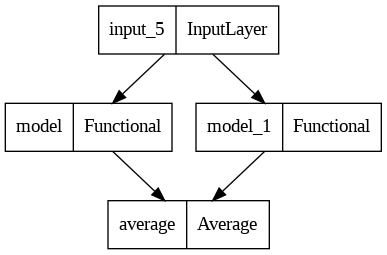

In [ ]:
# Illustrating the model:
plot_model(average_ensemble_base_B)

In [26]:
# Defining the average ensemble model function with fine-tuned models:
def create_average_ensemble_fine_B(input_shape, neurons_out):
  models = [convnext_model,
            vit_model]
  input = Input(shape = input_shape)
  outputs = [model(input) for model in models]
  output = Average()(outputs)
  ensemble_model = Model(input, output)
  return ensemble_model

In [27]:
# Creating the average ensemble model:
average_ensemble_fine_B = create_average_ensemble_fine_B(input_shape = SIZE,
                                                         neurons_out = 28)

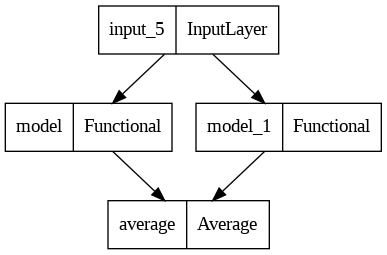

In [ ]:
# Illustrating the model:
plot_model(average_ensemble_fine_B)

## *6. Model Training & Evaluation:*

In [ ]:
# Defining LearningRateScheduler:
def scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return 0.0001

lr_scheduler = LearningRateScheduler(scheduler)

In [ ]:
# Defining BackupAndRestore:
restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/AUG/backup',
                           save_freq = 'epoch',
                           delete_checkpoint = True)

In [ ]:
# Creating callback list:
callbacks_list = [restore,
                  lr_scheduler]

In [ ]:
# History plot function:
def show_history(history):
    fig, ax = plt.subplots(1, 2, figsize = (15, 5))
    ax[0].set_title('Loss')
    ax[0].plot(history.epoch, history.history['loss'], label = 'Train loss')
    ax[0].plot(history.epoch, history.history['val_loss'], label = 'Test loss')
    ax[1].set_title('Accuracy')
    ax[1].plot(history.epoch, history.history['binary_accuracy'], label = 'Train accuracy')
    ax[1].plot(history.epoch, history.history['val_binary_accuracy'], label = 'Test accuracy')
    ax[0].legend()
    ax[1].legend()

### 6.1 EfficientNet-V2M:

In [ ]:
# Compiling the EfficientNet-V2M model:
efficientnet_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the EfficientNet-V2M model:
efficientnet_start_time = time.time()

efficientnet_history = efficientnet_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

efficientnet_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 347s 354ms/step - loss: 0.0496 - binary_accuracy: 0.9411 - precision: 0.4806 - recall: 0.1217 - auc: 0.5627 - val_loss: 0.0464 - val_binary_accuracy: 0.9461 - val_precision: 0.6487 - val_recall: 0.1901 - val_auc: 0.6103 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 301s 345ms/step - loss: 0.0456 - binary_accuracy: 0.9456 - precision: 0.6214 - recall: 0.1694 - auc: 0.6215 - val_loss: 0.0441 - val_binary_accuracy: 0.9474 - val_precision: 0.6879 - val_recall: 0.2018 - val_auc: 0.6633 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 302s 346ms/step - loss: 0.0443 - binary_accuracy: 0.9465 - precision: 0.6350 - recall: 0.1948 - auc: 0.6720 - val_loss: 0.0433 - val_binary_accuracy: 0.9479 - val_precision: 0.6936 - val_recall: 0.2120 - val_auc: 0.6810 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 301s 345ms/step - loss: 0.0435 - binary_accuracy: 0.9475 - precision: 0.6479 - recall

In [ ]:
# Saving the EfficientNet-V2M model:
efficientnet_model.save('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-EfficientNet-V2M.h5')

In [ ]:
# Total time taken to train EfficientNet-V2M model:
print("Time taken:", efficientnet_end_time - efficientnet_start_time, "seconds.")

Time taken: 9109.139063835144 seconds.


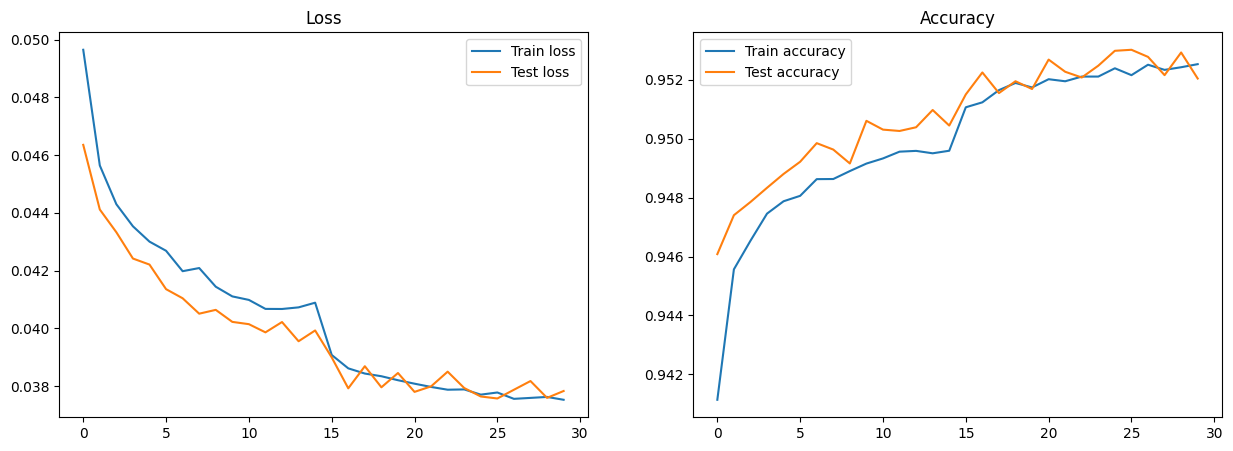

In [ ]:
# EfficientNet_V2M model train & test history plot:
show_history(efficientnet_history)

In [ ]:
# Evaluating the EfficientNet-V2M model:
efficientnet_evaluate = efficientnet_model.evaluate(test_generator,
                                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                    verbose = 1)

98/98 [==============================] - 27s 273ms/step - loss: 0.0375 - binary_accuracy: 0.9534 - precision: 0.7236 - recall: 0.3354 - auc: 0.7989


In [ ]:
# Extracting EfficientNet_V2M model metrics:
efficientnet_test_accuracy, efficientnet_test_precision, efficientnet_test_recall, efficientnet_test_auc = efficientnet_evaluate[1:]
efficientnet_test_f1 = 2 * (efficientnet_test_precision * efficientnet_test_recall) / (efficientnet_test_precision + efficientnet_test_recall)

print('EfficientNet_V2M Test Accuracy:', efficientnet_test_accuracy)
print('EfficientNet_V2M Test AUC-score:', efficientnet_test_auc)
print('EfficientNet_V2M Test F1-score:', efficientnet_test_f1)
print('EfficientNet_V2M Test Precision:', efficientnet_test_precision)
print('EfficientNet_V2M Test Recall:', efficientnet_test_recall)

EfficientNet_V2M Test Accuracy: 0.9533576965332031
EfficientNet_V2M Test AUC-score: 0.7989382147789001
EfficientNet_V2M Test F1-score: 0.45829440617094
EfficientNet_V2M Test Precision: 0.7235566973686218
EfficientNet_V2M Test Recall: 0.3353515565395355


### 6.2 ConvNeXt-B:

In [ ]:
# Compiling the ConvNeXt-B model:
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ConvNeXt-B model:
convnext_start_time = time.time()

convnext_history = convnext_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

convnext_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 382s 381ms/step - loss: 0.0473 - binary_accuracy: 0.9435 - precision: 0.5463 - recall: 0.1852 - auc: 0.6380 - val_loss: 0.0421 - val_binary_accuracy: 0.9478 - val_precision: 0.6861 - val_recall: 0.2134 - val_auc: 0.7024 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 304s 347ms/step - loss: 0.0420 - binary_accuracy: 0.9484 - precision: 0.6472 - recall: 0.2509 - auc: 0.7093 - val_loss: 0.0409 - val_binary_accuracy: 0.9499 - val_precision: 0.6990 - val_recall: 0.2677 - val_auc: 0.7224 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 304s 348ms/step - loss: 0.0409 - binary_accuracy: 0.9493 - precision: 0.6579 - recall: 0.2697 - auc: 0.7491 - val_loss: 0.0402 - val_binary_accuracy: 0.9497 - val_precision: 0.6975 - val_recall: 0.2635 - val_auc: 0.7326 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 303s 347ms/step - loss: 0.0401 - binary_accuracy: 0.9500 - precision: 0.6667 - recall

In [ ]:
# Saving the ConvNeXt-B model:
convnext_model.save('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ConvNeXt-B.h5')

In [ ]:
# Total time taken to train ConvNeXt-B model:
print("Time taken:", convnext_end_time - convnext_start_time, "seconds.")

Time taken: 9197.778123378754 seconds.


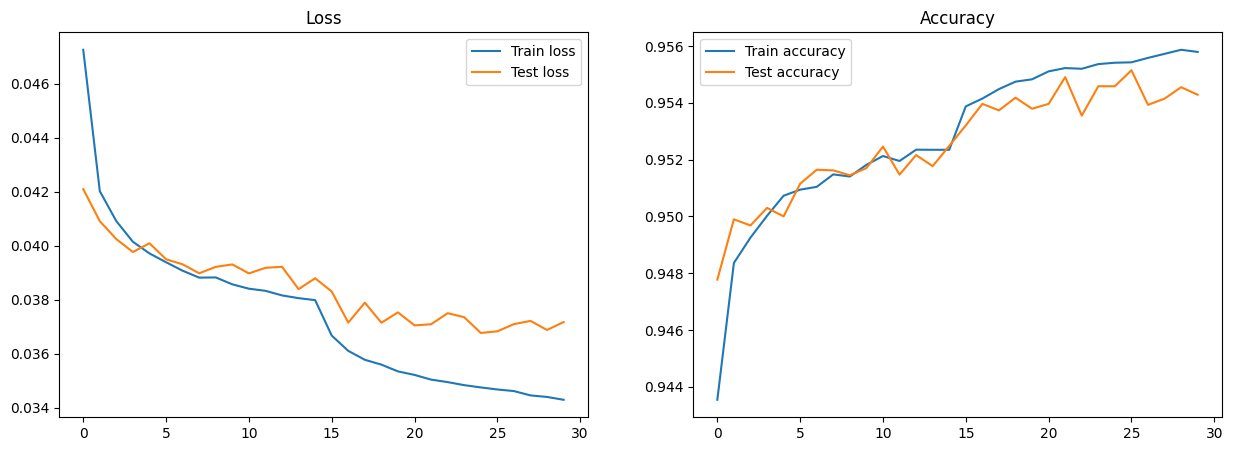

In [ ]:
# ConvNeXt-B model train & test history plot:
show_history(convnext_history)

In [ ]:
# Evaluating the ConvNeXt-B model:
convnext_evaluate = convnext_model.evaluate(test_generator,
                                            steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                            verbose = 1)

98/98 [==============================] - 27s 274ms/step - loss: 0.0367 - binary_accuracy: 0.9550 - precision: 0.7450 - recall: 0.3566 - auc: 0.7848


In [ ]:
# Extracting ConvNeXt-B model metrics:
convnext_test_accuracy, convnext_test_precision, convnext_test_recall, convnext_test_auc = convnext_evaluate[1:]
convnext_test_f1 = 2 * (convnext_test_precision * convnext_test_recall) / (convnext_test_precision + convnext_test_recall)

print('ConvNeXt-B Test Accuracy:', convnext_test_accuracy)
print('ConvNeXt-B Test AUC-score:', convnext_test_auc)
print('ConvNeXt-B Test F1-score:', convnext_test_f1)
print('ConvNeXt-B Test Precision:', convnext_test_precision)
print('ConvNeXt-B Test Recall:', convnext_test_recall)

ConvNeXt-B Test Accuracy: 0.9549664855003357
ConvNeXt-B Test AUC-score: 0.7847545742988586
ConvNeXt-B Test F1-score: 0.48236693551882154
ConvNeXt-B Test Precision: 0.745002031326294
ConvNeXt-B Test Recall: 0.35664063692092896


### 6.3 ViT-B16:

In [ ]:
# Compiling the ViT-B16 model:
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ViT-B16 model:
vit_start_time = time.time()

vit_history = vit_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

vit_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 339s 353ms/step - loss: 0.0488 - binary_accuracy: 0.9431 - precision: 0.5277 - recall: 0.2267 - auc: 0.6503 - val_loss: 0.0410 - val_binary_accuracy: 0.9497 - val_precision: 0.7219 - val_recall: 0.2414 - val_auc: 0.7374 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 301s 345ms/step - loss: 0.0426 - binary_accuracy: 0.9484 - precision: 0.6536 - recall: 0.2444 - auc: 0.7327 - val_loss: 0.0401 - val_binary_accuracy: 0.9507 - val_precision: 0.7345 - val_recall: 0.2597 - val_auc: 0.7482 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 300s 343ms/step - loss: 0.0419 - binary_accuracy: 0.9487 - precision: 0.6551 - recall: 0.2540 - auc: 0.7499 - val_loss: 0.0399 - val_binary_accuracy: 0.9500 - val_precision: 0.7164 - val_recall: 0.2567 - val_auc: 0.7681 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 300s 343ms/step - loss: 0.0414 - binary_accuracy: 0.9490 - precision: 0.6563 - recall

In [ ]:
# Saving the ViT-B16 model:
vit_model.save('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ViT-B16.h5')

In [ ]:
# Total time taken to train ViT-B16 model:
print("Time taken:", vit_end_time - vit_start_time, "seconds.")

Time taken: 9066.729115247726 seconds.


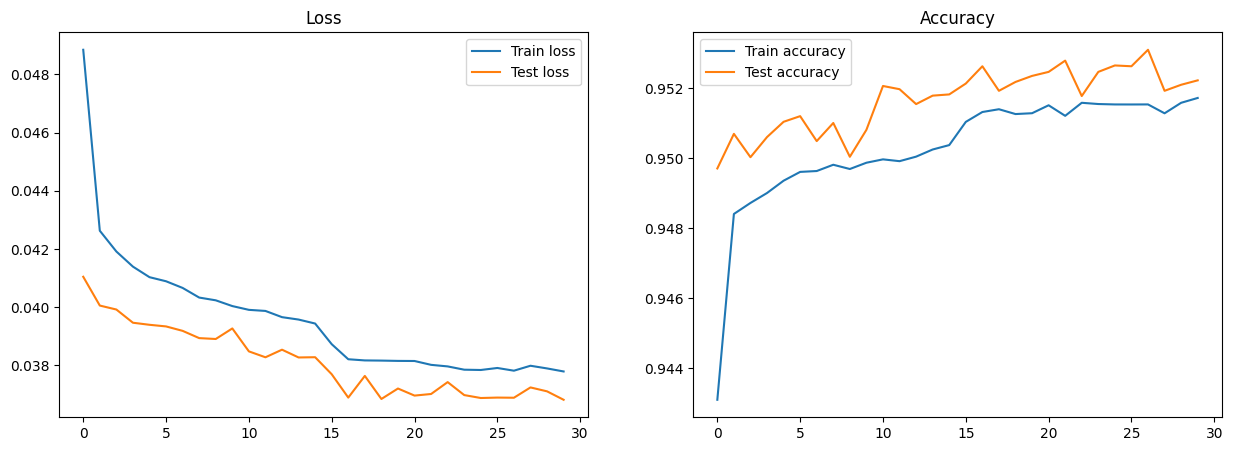

In [ ]:
# ViT-B16 model train & test history plot:
show_history(vit_history)

In [ ]:
# Evaluating the ViT-B16 model:
vit_evaluate = vit_model.evaluate(test_generator,
                                  steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                  verbose = 1)

98/98 [==============================] - 27s 275ms/step - loss: 0.0369 - binary_accuracy: 0.9529 - precision: 0.7282 - recall: 0.3187 - auc: 0.8110


In [ ]:
# Extracting ViT-B16 model metrics:
vit_test_accuracy, vit_test_precision, vit_test_recall, vit_test_auc = vit_evaluate[1:]
vit_test_f1 = 2 * (vit_test_precision * vit_test_recall) / (vit_test_precision + vit_test_recall)

print('ViT-B16 Test Accuracy:', vit_test_accuracy)
print('ViT-B16 Test AUC-score:', vit_test_auc)
print('ViT-B16 Test F1-score:', vit_test_f1)
print('ViT-B16 Test Precision:', vit_test_precision)
print('ViT-B16 Test Recall:', vit_test_recall)

ViT-B16 Test Accuracy: 0.9529209136962891
ViT-B16 Test AUC-score: 0.8109933137893677
ViT-B16 Test F1-score: 0.44341801042645074
ViT-B16 Test Precision: 0.7282463312149048
ViT-B16 Test Recall: 0.3187499940395355


### 6.4 Swin-B Transformer:

In [ ]:
# Compiling the Swin-B Transformer model:
swin_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the Swin-B Transformer model:
swin_start_time = time.time()

swin_history = swin_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = callbacks_list)

swin_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 365s 365ms/step - loss: 0.0570 - binary_accuracy: 0.9350 - precision: 0.3144 - recall: 0.0970 - auc: 0.5377 - val_loss: 0.0455 - val_binary_accuracy: 0.9427 - val_precision: 0.5720 - val_recall: 0.1175 - val_auc: 0.6362 - lr: 0.0010
Epoch 2/30
874/874 [==============================] - 307s 352ms/step - loss: 0.0463 - binary_accuracy: 0.9432 - precision: 0.5589 - recall: 0.1245 - auc: 0.6085 - val_loss: 0.0435 - val_binary_accuracy: 0.9464 - val_precision: 0.6758 - val_recall: 0.1783 - val_auc: 0.6699 - lr: 0.0010
Epoch 3/30
874/874 [==============================] - 307s 351ms/step - loss: 0.0449 - binary_accuracy: 0.9449 - precision: 0.5988 - recall: 0.1644 - auc: 0.6399 - val_loss: 0.0427 - val_binary_accuracy: 0.9474 - val_precision: 0.7195 - val_recall: 0.1809 - val_auc: 0.6758 - lr: 0.0010
Epoch 4/30
874/874 [==============================] - 308s 353ms/step - loss: 0.0441 - binary_accuracy: 0.9456 - precision: 0.6150 - recall

In [ ]:
# Saving the Swin-B Transformer model:
swin_model.save('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-Swin-B.h5')

In [ ]:
# Total time taken to train Swin-B Transformer model:
print("Time taken:", swin_end_time - swin_start_time, "seconds.")

Time taken: 9264.894195318222 seconds.


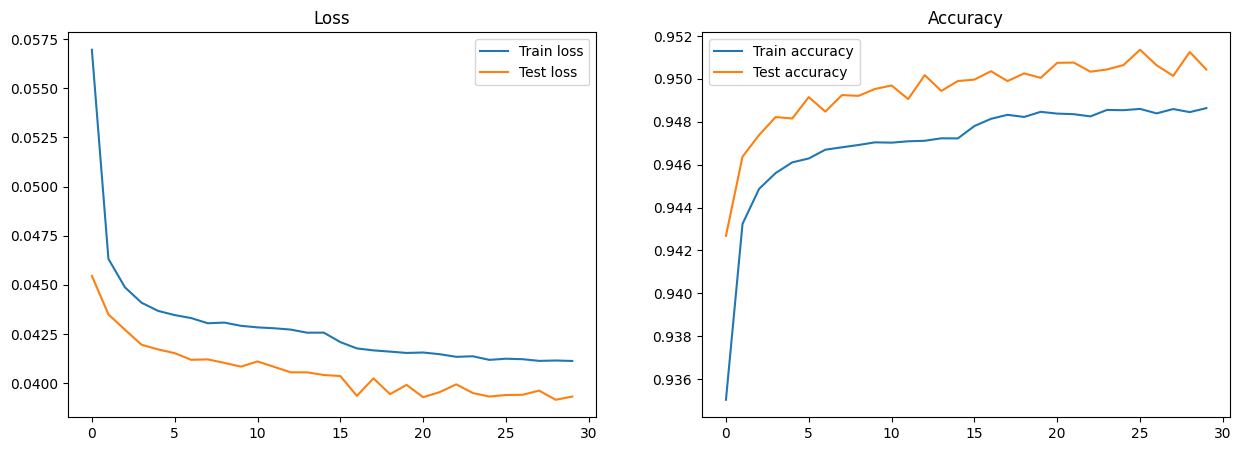

In [ ]:
# Swin-B Transformer model train & test history plot:
show_history(swin_history)

In [ ]:
# Evaluating the Swin-B Transformer model:
swin_evaluate = swin_model.evaluate(test_generator,
                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                    verbose = 1)

98/98 [==============================] - 27s 277ms/step - loss: 0.0390 - binary_accuracy: 0.9515 - precision: 0.7153 - recall: 0.2910 - auc: 0.7491


In [ ]:
# Extracting Swin-B Transformer model metrics:
swin_test_accuracy, swin_test_precision, swin_test_recall, swin_test_auc = swin_evaluate[1:]
swin_test_f1 = 2 * (swin_test_precision * swin_test_recall) / (swin_test_precision + swin_test_recall)

print('Swin-B Transformer Test Accuracy:', swin_test_accuracy)
print('Swin-B Transformer Test AUC-score:', swin_test_auc)
print('Swin-B Transformer Test F1-score:', swin_test_f1)
print('Swin-B Transformer Test Precision:', swin_test_precision)
print('Swin-B Transformer Test Recall:', swin_test_recall)

Swin-B Transformer Test Accuracy: 0.9514734148979187
Swin-B Transformer Test AUC-score: 0.7491486668586731
Swin-B Transformer Test F1-score: 0.4137165066041578
Swin-B Transformer Test Precision: 0.7153144478797913
Swin-B Transformer Test Recall: 0.291015625


### 6.5 Ensemble Model:

#### 6.5.1  Average Ensemble:

In [ ]:
# Compiling the base average ensemble model:
average_ensemble_base_B.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-3),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the average ensemble model:
average_base_start_time = time.time()

average_base_history = average_ensemble_base_B.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = 20, # Lower epochs here, in order to cope with overfitting!
    verbose = 1,
    callbacks = callbacks_list)

average_base_end_time = time.time()

Epoch 1/20
874/874 [==============================] - 454s 440ms/step - loss: 0.0348 - binary_accuracy: 0.9553 - precision: 0.7203 - recall: 0.3811 - auc: 0.8564 - val_loss: 0.0355 - val_binary_accuracy: 0.9558 - val_precision: 0.7330 - val_recall: 0.3963 - val_auc: 0.8216 - lr: 0.0010
Epoch 2/20
874/874 [==============================] - 348s 398ms/step - loss: 0.0347 - binary_accuracy: 0.9553 - precision: 0.7134 - recall: 0.3908 - auc: 0.8575 - val_loss: 0.0355 - val_binary_accuracy: 0.9552 - val_precision: 0.7391 - val_recall: 0.3734 - val_auc: 0.8193 - lr: 0.0010
Epoch 3/20
874/874 [==============================] - 348s 398ms/step - loss: 0.0348 - binary_accuracy: 0.9553 - precision: 0.7124 - recall: 0.3917 - auc: 0.8567 - val_loss: 0.0357 - val_binary_accuracy: 0.9549 - val_precision: 0.7292 - val_recall: 0.3783 - val_auc: 0.8208 - lr: 0.0010
Epoch 4/20
874/874 [==============================] - 348s 398ms/step - loss: 0.0345 - binary_accuracy: 0.9555 - precision: 0.7160 - recall

In [ ]:
# Saving the base average ensemble model:
average_ensemble_base_B.save('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-Average.h5')

In [ ]:
# Total time taken to train average ensemble model:
print("Time taken:", average_base_end_time - average_base_start_time, "seconds.")

Time taken: 7077.945861816406 seconds.


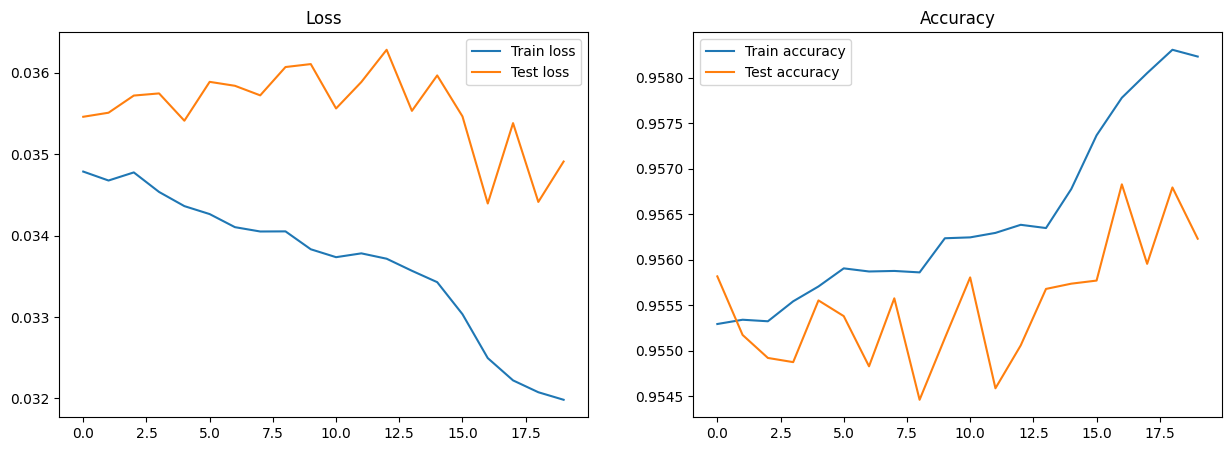

In [ ]:
# Average ensemble model train & test history plot:
show_history(average_base_history)

In [ ]:
# Evaluating the base average ensemble model:
average_base = average_ensemble_base_B.evaluate(test_generator,
                                                steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                verbose = 1)

98/98 [==============================] - 28s 284ms/step - loss: 0.0351 - binary_accuracy: 0.9563 - precision: 0.7330 - recall: 0.4076 - auc: 0.8213


In [ ]:
# Extracting base average ensemble model metrics:
average_base_test_accuracy, average_base_test_precision, average_base_test_recall, average_base_test_auc = average_base[1:]
average_base_test_f1 = 2 * (average_base_test_precision * average_base_test_recall) / (average_base_test_precision + average_base_test_recall)

print('Base Average Ensemble Model Test Accuracy:', average_base_test_accuracy)
print('Base Average Ensemble Model Test AUC-score:', average_base_test_auc)
print('Base Average Ensemble Model Test F1-score:', average_base_test_f1)
print('Base Average Ensemble Model Test Precision:', average_base_test_precision)
print('Base Average Ensemble Model Test Recall:', average_base_test_recall)

Base Average Ensemble Model Test Accuracy: 0.9563108682632446
Base Average Ensemble Model Test AUC-score: 0.8213459253311157
Base Average Ensemble Model Test F1-score: 0.5239168470365175
Base Average Ensemble Model Test Precision: 0.7330062985420227
Base Average Ensemble Model Test Recall: 0.4076383411884308


## *7. Fine-tuning & Evaluation:*

In [ ]:
# Defining LearningRateScheduler for fine-tuning:
def fine_scheduler(epoch, lr):
  if epoch < 15:
    return lr
  else:
    return 0.00001

fine_lr_scheduler = LearningRateScheduler(fine_scheduler)

In [ ]:
# Defining BackupAndRestore for fine-tuning:
fine_restore = BackupAndRestore(backup_dir = '/content/drive/MyDrive/BACKUPS/AUG/backup',
                                save_freq = 'epoch',
                                delete_checkpoint = True)

In [ ]:
# Creating callback list:
fine_callbacks_list = [fine_restore,
                       fine_lr_scheduler]

### 7.1 EfficientNet-V2M:

In [ ]:
# Unfreezing the EfficientNet-V2M model layers:
for layer in efficientnet_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the EfficientNet-V2M model:
efficientnet_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the EfficientNet_V2M model:
efficientnet_start_time = time.time()

efficientnet_history = efficientnet_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

efficientnet_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 365s 359ms/step - loss: 0.0406 - binary_accuracy: 0.9507 - precision: 0.6823 - recall: 0.2892 - auc: 0.7689 - val_loss: 0.0351 - val_binary_accuracy: 0.9566 - val_precision: 0.7551 - val_recall: 0.3957 - val_auc: 0.8199 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 310s 355ms/step - loss: 0.0340 - binary_accuracy: 0.9569 - precision: 0.7355 - recall: 0.4062 - auc: 0.8519 - val_loss: 0.0321 - val_binary_accuracy: 0.9594 - val_precision: 0.7667 - val_recall: 0.4578 - val_auc: 0.8450 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 313s 359ms/step - loss: 0.0314 - binary_accuracy: 0.9601 - precision: 0.7584 - recall: 0.4623 - auc: 0.8800 - val_loss: 0.0307 - val_binary_accuracy: 0.9614 - val_precision: 0.7727 - val_recall: 0.4819 - val_auc: 0.8610 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 307s 351ms/step - loss: 0.0296 - binary_accuracy: 0.9621 - precision: 0.7

In [ ]:
# Saving the fine-tuned EfficientNet-V2M model:
efficientnet_model.save('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-EfficientNet-V2M.h5')

In [ ]:
# Total time taken to train EfficientNet-V2M model:
print("Time taken:", efficientnet_end_time - efficientnet_start_time, "seconds.")

Time taken: 9430.236449718475 seconds.


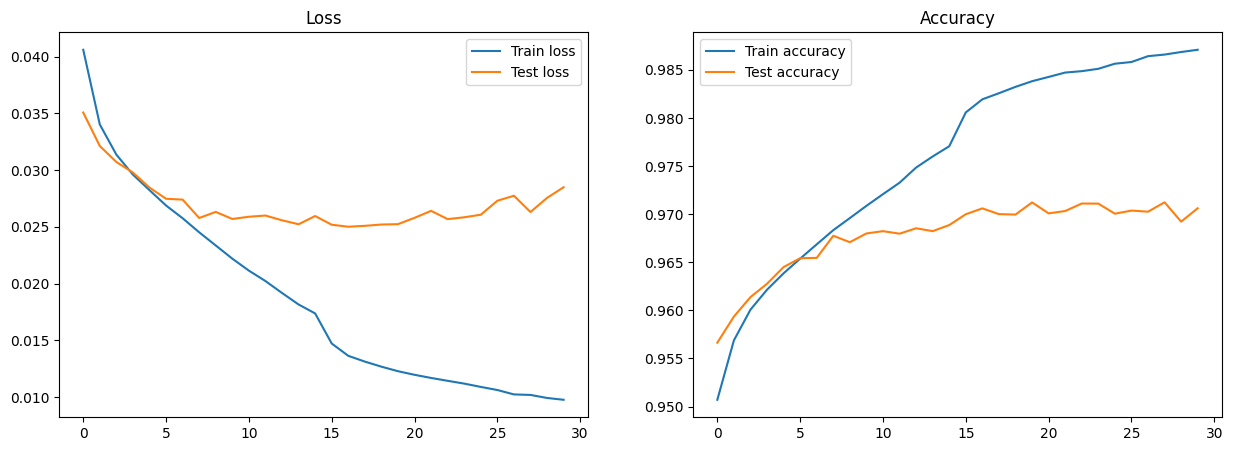

In [ ]:
# EfficientNet_V2M model train & test history plot:
show_history(efficientnet_history)

In [ ]:
# Evaluating the EfficientNet-V2M model:
efficientnet_evaluate = efficientnet_model.evaluate(test_generator,
                                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                    verbose = 1)

98/98 [==============================] - 27s 279ms/step - loss: 0.0272 - binary_accuracy: 0.9710 - precision: 0.7817 - recall: 0.7046 - auc: 0.9097


In [ ]:
# Extracting EfficientNet_V2M model metrics:
efficientnet_test_accuracy, efficientnet_test_precision, efficientnet_test_recall, efficientnet_test_auc = efficientnet_evaluate[1:]
efficientnet_test_f1 = 2 * (efficientnet_test_precision * efficientnet_test_recall) / (efficientnet_test_precision + efficientnet_test_recall)

print('EfficientNet_V2M Test Accuracy:', efficientnet_test_accuracy)
print('EfficientNet_V2M Test AUC-score:', efficientnet_test_auc)
print('EfficientNet_V2M Test F1-score:', efficientnet_test_f1)
print('EfficientNet_V2M Test Precision:', efficientnet_test_precision)
print('EfficientNet_V2M Test Recall:', efficientnet_test_recall)

EfficientNet_V2M Test Accuracy: 0.970973551273346
EfficientNet_V2M Test AUC-score: 0.9096678495407104
EfficientNet_V2M Test F1-score: 0.7411354893941497
EfficientNet_V2M Test Precision: 0.7816688418388367
EfficientNet_V2M Test Recall: 0.704598605632782


### 7.2 ConvNeXt-B:

In [ ]:
# Unfreezing the ConvNeXt-B model layers:
for layer in convnext_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the ConvNeXt-B model:
convnext_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ConvNeXt-B model:
convnext_start_time = time.time()

convnext_history = convnext_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

convnext_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 338s 359ms/step - loss: 0.0445 - binary_accuracy: 0.9483 - precision: 0.6927 - recall: 0.2049 - auc: 0.6627 - val_loss: 0.0392 - val_binary_accuracy: 0.9513 - val_precision: 0.6896 - val_recall: 0.3235 - val_auc: 0.7740 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 309s 353ms/step - loss: 0.0348 - binary_accuracy: 0.9564 - precision: 0.7262 - recall: 0.4051 - auc: 0.8308 - val_loss: 0.0325 - val_binary_accuracy: 0.9591 - val_precision: 0.7887 - val_recall: 0.4285 - val_auc: 0.8349 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 306s 350ms/step - loss: 0.0309 - binary_accuracy: 0.9612 - precision: 0.7640 - recall: 0.4844 - auc: 0.8755 - val_loss: 0.0299 - val_binary_accuracy: 0.9624 - val_precision: 0.7910 - val_recall: 0.4853 - val_auc: 0.8566 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 307s 352ms/step - loss: 0.0288 - binary_accuracy: 0.9636 - precision: 0.7

In [ ]:
# Saving the fine-tuned ConvNeXt-B model:
convnext_model.save('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ConvNeXt-B.h5')

In [ ]:
# Total time taken to train ConvNeXt-B model:
print("Time taken:", convnext_end_time - convnext_start_time, "seconds.")

Time taken: 9264.8743288517 seconds.


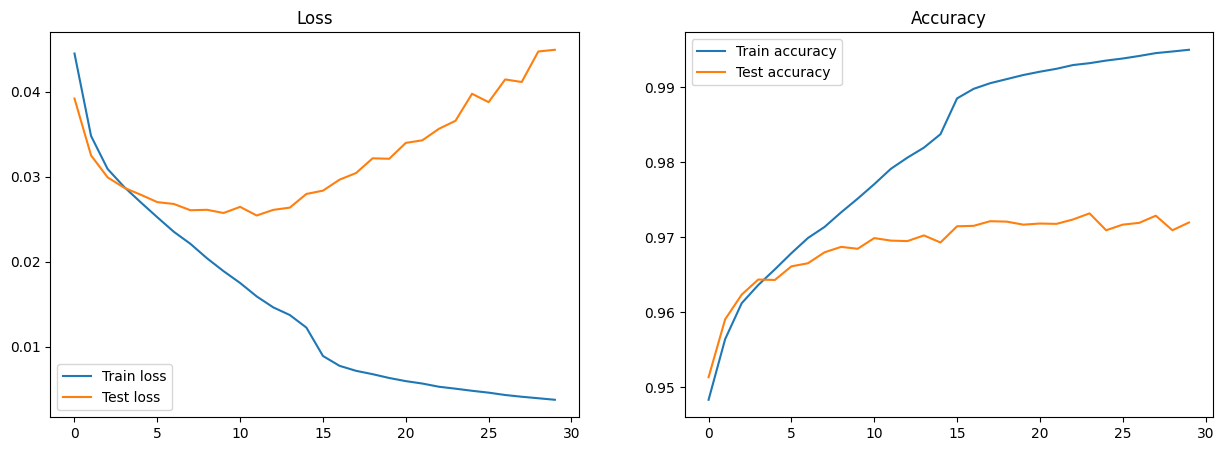

In [ ]:
# ConvNeXt-B model train & test history plot:
show_history(convnext_history)

In [ ]:
# Evaluating the ConvNeXt-B model:
convnext_evaluate = convnext_model.evaluate(test_generator,
                                            steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                            verbose = 1)

98/98 [==============================] - 27s 281ms/step - loss: 0.0437 - binary_accuracy: 0.9721 - precision: 0.7754 - recall: 0.7414 - auc: 0.8983


In [ ]:
# Extracting ConvNeXt-B model metrics:
convnext_test_accuracy, convnext_test_precision, convnext_test_recall, convnext_test_auc = convnext_evaluate[1:]
convnext_test_f1 = 2 * (convnext_test_precision * convnext_test_recall) / (convnext_test_precision + convnext_test_recall)

print('ConvNeXt-B Test Accuracy:', convnext_test_accuracy)
print('ConvNeXt-B Test AUC-score:', convnext_test_auc)
print('ConvNeXt-B Test F1-score:', convnext_test_f1)
print('ConvNeXt-B Test Precision:', convnext_test_precision)
print('ConvNeXt-B Test Recall:', convnext_test_recall)

ConvNeXt-B Test Accuracy: 0.972088098526001
ConvNeXt-B Test AUC-score: 0.8982569575309753
ConvNeXt-B Test F1-score: 0.7580436348091768
ConvNeXt-B Test Precision: 0.7754228711128235
ConvNeXt-B Test Recall: 0.7414263486862183


### 7.3 ViT-B16:

In [ ]:
# Unfreezing the ViT-B16 model layers:
for layer in vit_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the ViT-B16 model:
vit_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the ViT-B16 model:
vit_start_time = time.time()

vit_history = vit_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

vit_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 336s 358ms/step - loss: 0.0365 - binary_accuracy: 0.9538 - precision: 0.7030 - recall: 0.3589 - auc: 0.8284 - val_loss: 0.0326 - val_binary_accuracy: 0.9581 - val_precision: 0.7904 - val_recall: 0.3984 - val_auc: 0.8493 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 311s 356ms/step - loss: 0.0324 - binary_accuracy: 0.9580 - precision: 0.7407 - recall: 0.4311 - auc: 0.8772 - val_loss: 0.0309 - val_binary_accuracy: 0.9596 - val_precision: 0.7917 - val_recall: 0.4385 - val_auc: 0.8693 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 310s 355ms/step - loss: 0.0301 - binary_accuracy: 0.9610 - precision: 0.7632 - recall: 0.4792 - auc: 0.8982 - val_loss: 0.0303 - val_binary_accuracy: 0.9606 - val_precision: 0.7757 - val_recall: 0.4609 - val_auc: 0.8785 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 309s 354ms/step - loss: 0.0280 - binary_accuracy: 0.9631 - precision: 0.7

In [ ]:
# Saving the fine-tuned ViT-B16 model:
vit_model.save('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ViT-B16.h5')

In [ ]:
# Total time taken to train ViT-B16 model:
print("Time taken:", vit_end_time - vit_start_time, "seconds.")

Time taken: 9212.897802591324 seconds.


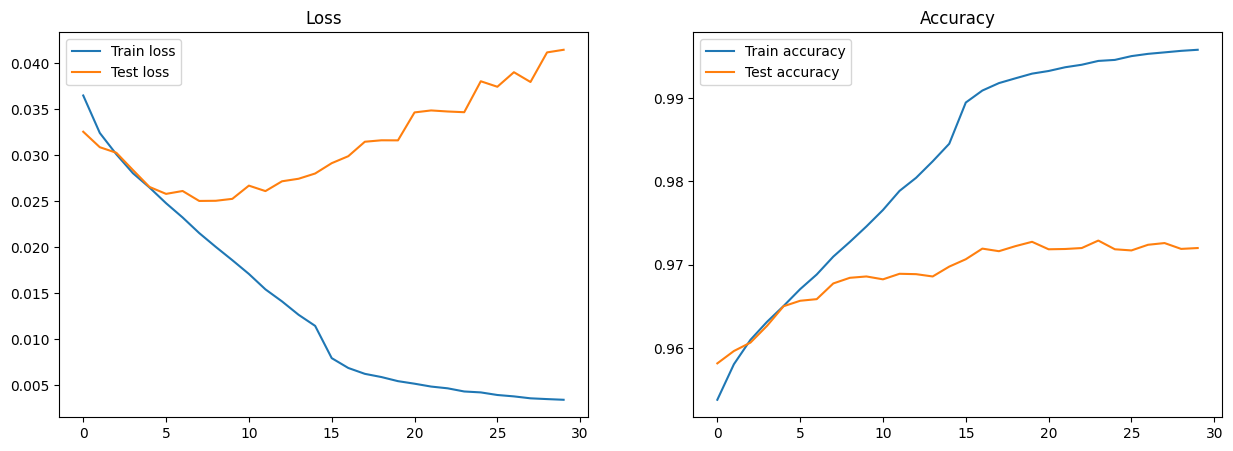

In [ ]:
# ViT-B16 model train & test history plot:
show_history(vit_history)

In [ ]:
# Evaluating the ViT-B16 model:
vit_evaluate = vit_model.evaluate(test_generator,
                                  steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                  verbose = 1)

98/98 [==============================] - 27s 274ms/step - loss: 0.0411 - binary_accuracy: 0.9726 - precision: 0.7905 - recall: 0.7292 - auc: 0.9134


In [ ]:
# Extracting ViT-B16 model metrics:
vit_test_accuracy, vit_test_precision, vit_test_recall, vit_test_auc = vit_evaluate[1:]
vit_test_f1 = 2 * (vit_test_precision * vit_test_recall) / (vit_test_precision + vit_test_recall)

print('ViT-B16 Test Accuracy:', vit_test_accuracy)
print('ViT-B16 Test AUC-score:', vit_test_auc)
print('ViT-B16 Test F1-score:', vit_test_f1)
print('ViT-B16 Test Precision:', vit_test_precision)
print('ViT-B16 Test Recall:', vit_test_recall)

ViT-B16 Test Accuracy: 0.9726283550262451
ViT-B16 Test AUC-score: 0.9133637547492981
ViT-B16 Test F1-score: 0.7585647666785528
ViT-B16 Test Precision: 0.7904520630836487
ViT-B16 Test Recall: 0.7291504144668579


###7.4 Swin-B Transformer:

In [ ]:
# Unfreezing the Swin-B Transformer model layers:
for layer in swin_model.layers:
    layer.trainable = True

In [ ]:
# Compiling the Swin-B Transformer model:
swin_model.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4), # Lower learning-rate in this stage! Otherwise, risk on overfitting!
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the Swin-B Transformer model:
swin_start_time = time.time()

swin_history = swin_model.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = epochs, 
    verbose = 1,
    callbacks = fine_callbacks_list)

swin_end_time = time.time()

Epoch 1/30
874/874 [==============================] - 374s 373ms/step - loss: 0.0412 - binary_accuracy: 0.9492 - precision: 0.6679 - recall: 0.2554 - auc: 0.7386 - val_loss: 0.0370 - val_binary_accuracy: 0.9520 - val_precision: 0.7232 - val_recall: 0.3054 - val_auc: 0.8021 - lr: 1.0000e-04
Epoch 2/30
874/874 [==============================] - 313s 358ms/step - loss: 0.0381 - binary_accuracy: 0.9519 - precision: 0.7050 - recall: 0.3013 - auc: 0.7857 - val_loss: 0.0364 - val_binary_accuracy: 0.9530 - val_precision: 0.7446 - val_recall: 0.3235 - val_auc: 0.8134 - lr: 1.0000e-04
Epoch 3/30
874/874 [==============================] - 313s 358ms/step - loss: 0.0365 - binary_accuracy: 0.9537 - precision: 0.7223 - recall: 0.3329 - auc: 0.8177 - val_loss: 0.0340 - val_binary_accuracy: 0.9569 - val_precision: 0.7973 - val_recall: 0.3530 - val_auc: 0.8228 - lr: 1.0000e-04
Epoch 4/30
874/874 [==============================] - 313s 359ms/step - loss: 0.0350 - binary_accuracy: 0.9551 - precision: 0.7

In [ ]:
# Saving the fine-tuned Swin-B Transformer model:
swin_model.save('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-Swin-B.h5')

In [ ]:
# Total time taken to train Swin-B Transformer model:
print("Time taken:", swin_end_time - swin_start_time, "seconds.")

Time taken: 9482.88167309761 seconds.


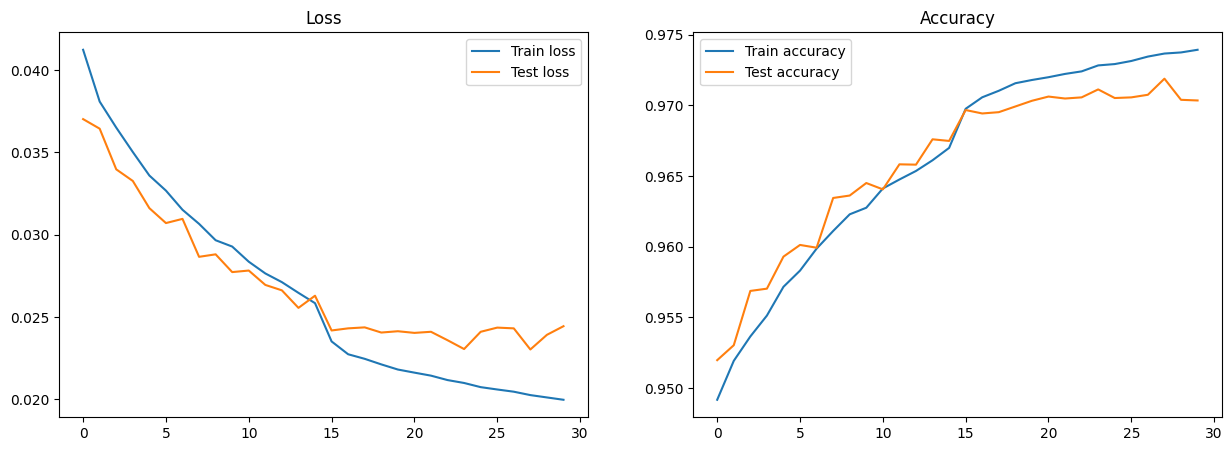

In [ ]:
# Swin-B Transformer model train & test history plot:
show_history(swin_history)

In [ ]:
# Evaluating the Swin-B Transformer model:
swin_evaluate = swin_model.evaluate(test_generator,
                                    steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                    verbose = 1)

98/98 [==============================] - 28s 285ms/step - loss: 0.0236 - binary_accuracy: 0.9716 - precision: 0.8244 - recall: 0.6578 - auc: 0.9018


In [ ]:
# Extracting Swin-B Transformer model metrics:
swin_test_accuracy, swin_test_precision, swin_test_recall, swin_test_auc = swin_evaluate[1:]
swin_test_f1 = 2 * (swin_test_precision * swin_test_recall) / (swin_test_precision + swin_test_recall)

print('Swin-B Transformer Test Accuracy:', swin_test_accuracy)
print('Swin-B Transformer Test AUC-score:', swin_test_auc)
print('Swin-B Transformer Test F1-score:', swin_test_f1)
print('Swin-B Transformer Test Precision:', swin_test_precision)
print('Swin-B Transformer Test Recall:', swin_test_recall)

Swin-B Transformer Test Accuracy: 0.9715594053268433
Swin-B Transformer Test AUC-score: 0.9018265604972839
Swin-B Transformer Test F1-score: 0.7317654843935197
Swin-B Transformer Test Precision: 0.8244200348854065
Swin-B Transformer Test Recall: 0.6578332185745239


### 7.5 Ensemble Model:

#### 7.5.1  Average Ensemble:

In [28]:
# Unfreezing the average ensemble model layers:
for layer in average_ensemble_fine_B.layers:
    layer.trainable = True

In [29]:
# Compiling the average ensemble model:
average_ensemble_fine_B.compile(
    loss = BinaryFocalLoss(gamma = 2),
    optimizer = Adam(1e-4),
    metrics = ['binary_accuracy',
               tf.keras.metrics.Precision(name = 'precision'),
               tf.keras.metrics.Recall(name = 'recall'),
               tf.keras.metrics.AUC(name = 'auc',
                                    multi_label = True)])

In [ ]:
# Training the average ensemble model:
average_fine_start_time = time.time()

average_fine_history = average_ensemble_fine_B.fit(
    final_train_generator,
    steps_per_epoch = np.ceil(float(len(final_train_indexes)) / float(batch_size)),
    validation_data = test_generator,
    validation_steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
    epochs = 20, # Lower epochs here, in order to cope with overfitting!
    verbose = 1,
    callbacks = fine_callbacks_list)

average_fine_end_time = time.time()

Epoch 1/20
874/874 [==============================] - 529s 513ms/step - loss: 0.0051 - binary_accuracy: 0.9934 - precision: 0.9617 - recall: 0.9229 - auc: 0.9984 - val_loss: 0.0317 - val_binary_accuracy: 0.9719 - val_precision: 0.8048 - val_recall: 0.6920 - val_auc: 0.9149 - lr: 1.0000e-04
Epoch 2/20
874/874 [==============================] - 413s 473ms/step - loss: 0.0055 - binary_accuracy: 0.9930 - precision: 0.9579 - recall: 0.9208 - auc: 0.9954 - val_loss: 0.0310 - val_binary_accuracy: 0.9720 - val_precision: 0.8031 - val_recall: 0.6977 - val_auc: 0.9170 - lr: 1.0000e-04
Epoch 3/20
874/874 [==============================] - 413s 473ms/step - loss: 0.0052 - binary_accuracy: 0.9936 - precision: 0.9620 - recall: 0.9261 - auc: 0.9982 - val_loss: 0.0315 - val_binary_accuracy: 0.9728 - val_precision: 0.8062 - val_recall: 0.7119 - val_auc: 0.9116 - lr: 1.0000e-04
Epoch 4/20
874/874 [==============================] - 411s 470ms/step - loss: 0.0049 - binary_accuracy: 0.9939 - precision: 0.9

In [ ]:
# Saving the fine-tuned average ensemble model:
average_ensemble_fine_B.save('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-Average.h5')

In [ ]:
# Total time taken to train average ensemble model:
print("Time taken:", average_fine_end_time - average_fine_start_time, "seconds.")

Time taken: 8358.281964540482 seconds.


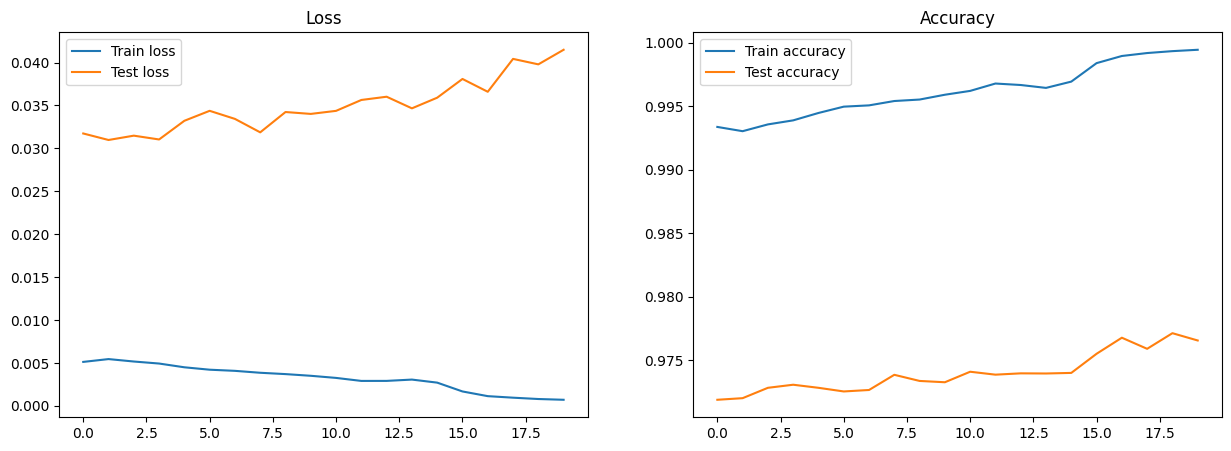

In [ ]:
# Average ensemble model train & test history plot:
show_history(average_fine_history)

In [ ]:
# Evaluating the fine-tuned average ensemble model:
average_fine = average_ensemble_fine_B.evaluate(test_generator,
                                                steps = np.ceil(float(len(test_indexes)) / float(batch_size)),
                                                verbose = 1)

98/98 [==============================] - 27s 280ms/step - loss: 0.0410 - binary_accuracy: 0.9764 - precision: 0.8326 - recall: 0.7514 - auc: 0.9153


In [ ]:
# Extracting fine-tuned average ensemble model metrics:
average_fine_test_accuracy, average_fine_test_precision, average_fine_test_recall, average_fine_test_auc = average_fine[1:]
average_fine_test_f1 = 2 * (average_fine_test_precision * average_fine_test_recall) / (average_fine_test_precision + average_fine_test_recall)

print('Fine-tuned Average Ensemble Model Test Accuracy:', average_fine_test_accuracy)
print('Fine-tuned Average Ensemble Model Test AUC-score:', average_fine_test_auc)
print('Fine-tuned Average Ensemble Model Test F1-score:', average_fine_test_f1)
print('Fine-tuned Average Ensemble Model Test Precision:', average_fine_test_precision)
print('Fine-tuned Average Ensemble Model Test Recall:', average_fine_test_recall)

Fine-tuned Average Ensemble Model Test Accuracy: 0.9764317274093628
Fine-tuned Average Ensemble Model Test AUC-score: 0.915287971496582
Fine-tuned Average Ensemble Model Test F1-score: 0.789921128888878
Fine-tuned Average Ensemble Model Test Precision: 0.8326495289802551
Fine-tuned Average Ensemble Model Test Recall: 0.75136399269104


## *8. External Testing:*

### 8.1 EfficientNet-V2M:

In [ ]:
# Submission EfficientNet-V2M base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
efficientnet_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-EfficientNet-V2M.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = efficientnet_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-AUG-EfficientNet-V2M.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-AUG-EfficientNet-V2M.csv', index = False)

In [ ]:
# Submission EfficientNet-V2M fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
efficientnet_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-EfficientNet-V2M.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = efficientnet_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-AUG-EfficientNet-V2M.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-AUG-EfficientNet-V2M.csv', index = False)

### 8.2 ConvNeXt-B:

In [ ]:
# Submission ConvNeXt-B base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
convnext_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ConvNeXt-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = convnext_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-AUG-ConvNeXt-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-AUG-ConvNeXt-B.csv', index = False)

In [ ]:
# Submission ConvNeXt-B fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
convnext_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ConvNeXt-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = convnext_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-AUG-ConvNeXt-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-AUG-ConvNeXt-B.csv', index = False)

###8.3 ViT-B16

In [ ]:
# Submission ViT-B16 base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
vit_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-ViT-B16.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = vit_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-AUG-ViT-B16.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-AUG-ViT-B16.csv', index = False)

In [ ]:
# Submission ViT-B16 fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
vit_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-ViT-B16.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = vit_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-AUG-ViT-B16.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-AUG-ViT-B16.csv', index = False)

###8.4 Swin-B Transformer:

In [ ]:
# Submission Swin-B Transformer base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
swin_model.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-Swin-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = swin_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-AUG-Swin-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-AUG-Swin-B.csv', index = False)

In [ ]:
# Submission Swin-B Transformer fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
swin_model.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-Swin-B.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = swin_model.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-AUG-Swin-B.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-AUG-Swin-B.csv', index = False)

###8.5 Ensemble Model:

In [ ]:
# Submission ensemble model base:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
average_ensemble_base_B.load_weights('/content/drive/MyDrive/MODELS-B/BASE/BASE-AUG-Average.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = average_ensemble_base_B.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/BASE-AUG-Average.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/BASE-AUG-Average.csv', index = False)

In [ ]:
# Submission ensemble model fine-tuned:
submit = pd.read_csv('/content/sample_submission.csv')
predicted = []
draw_predict = []
average_ensemble_fine_B.load_weights('/content/drive/MyDrive/MODELS-B/FINETUNED/FINE-AUG-Average.h5')
for name in tqdm(submit['Id']):
    path = os.path.join('/content/test/', name)
    image = data_generator.load_image(path, (224, 224, 3))/255.
    score_predict = average_ensemble_fine_B.predict(image[np.newaxis])[0]
    draw_predict.append(score_predict)
    label_predict = np.arange(28)[score_predict>=0.2]
    str_predict_label = ' '.join(str(l) for l in label_predict)
    predicted.append(str_predict_label)

submit['Predicted'] = predicted
np.save('/content/drive/MyDrive/EXTERNAL/FINE-AUG-Average.npy', score_predict)
submit.to_csv('/content/drive/MyDrive/EXTERNAL/FINE-AUG-Average.csv', index = False)

## REFERENCES:

* *Loading data & pre-processing:* https://www.kaggle.com/code/mathormad/inceptionv3-baseline-lb-0-379